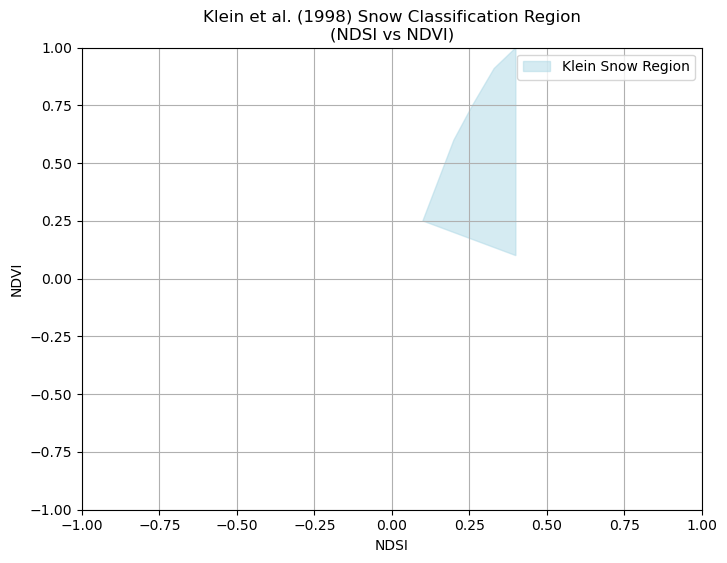

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import numpy as np

# Define approximate polygon (NDVI, NDSI) → flipped to (NDSI, NDVI)
region_coords = [
    (0.4, 1),
    (0.33, 0.91),
    (0.26, 0.75),
    (0.2, 0.6),
    (0.1, 0.25),  # bottom left
    (0.4, 0.1),  # top right
]

# Extract for plotting
polygon = Polygon(region_coords)
x_poly, y_poly = zip(*polygon.exterior.coords)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Shaded polygon
ax.fill(x_poly, y_poly, color='lightblue', alpha=0.5, label='Klein Snow Region')

# Axes and labels
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xlabel('NDSI')
ax.set_ylabel('NDVI')
ax.set_title('Klein et al. (1998) Snow Classification Region\n(NDSI vs NDVI)')
ax.grid(True)

ax.legend()
plt.show()


In [8]:
from scripts.imports import *
from rasterio.enums import Resampling
from shapely.geometry import Polygon, Point

def find_masks(folder, cam):
    for filename in os.listdir(folder):
        if cam in filename and 'LandCover' in filename:
            corine_filepath = os.path.join(folder, filename)
        elif cam in filename and 'ALOS' in filename:
            elevation_filepath = os.path.join(folder, filename)
    return corine_filepath, elevation_filepath

def load_and_reproject_to_landsat(source_path, match_array, band_name, method=Resampling.nearest):
    src = rioxarray.open_rasterio(source_path, masked=True).squeeze()
    src.name = band_name
    return src.rio.reproject_match(match_array, resampling=method)

def combine_tifs(landsat_filepath, corine_filepath, elevation_filepath):
    landsat = rioxarray.open_rasterio(landsat_filepath, masked=True).squeeze()
    landsat.name = "landsat"
    corine = load_and_reproject_to_landsat(corine_filepath, landsat, "corine_landcover")
    elevation = load_and_reproject_to_landsat(elevation_filepath, landsat, "elevation")
    return xr.merge([landsat, corine, elevation])

def apply_valid_mask(ds, e=80):
    elevation = ds['elevation']
    corine = ds['corine_landcover']
    yc, xc = elevation.sizes['y'] // 2, elevation.sizes['x'] // 2
    centre_elev = elevation.isel(y=yc, x=xc).item()
    elev_mask = np.abs(elevation - centre_elev) <= e
    corine_mask = (corine >= 111) & (corine <= 126)
    valid_mask = elev_mask & corine_mask
    ds['valid_mask'] = valid_mask
    return ds

def compute_ndvi(red, nir):
    return (nir - red) / (nir + red)

def compute_ndsi(green, swir):
    return (green - swir) / (green + swir)

def compute_dozier(ds, ndsi, nir):
    corine = ds['corine_landcover']
    condition1 = (ndsi > 0.1) & (ndsi < 0.4) # & (corine >= 111) & (corine <= 126)
    condition2 = (ndsi >= 0.4) & (nir > 0.11) # ~((corine >= 111) & (corine <= 126))
    dozier = xr.where(condition1 | condition2, 1, 0)
    return dozier.where(~np.isnan(ndsi))

def compute_klein(ndsi, ndvi, green, nir):
    region_coords = [
        (0.4, 1), (0.33, 0.91), (0.26, 0.75),
        (0.2, 0.6), (0.1, 0.25), (0.4, 0.1),
    ]
    polygon = Polygon(region_coords)
    klein = xr.zeros_like(ndsi)
    klein = xr.where(ndsi >= 0.4, 1, klein)
    ndsi_vals, ndvi_vals = ndsi.values, ndvi.values
    mask = np.zeros(ndsi.shape, dtype=bool)
    for i in range(ndsi.shape[0]):
        for j in range(ndsi.shape[1]):
            if not np.isnan(ndsi_vals[i, j]) and not np.isnan(ndvi_vals[i, j]):
                if polygon.contains(Point(ndsi_vals[i, j], ndvi_vals[i, j])):
                    mask[i, j] = True
    klein = xr.where(xr.DataArray(mask, dims=ndsi.dims, coords=ndsi.coords), 1, klein)
    klein = xr.where((green <= 0.1) | (nir <= 0.11), 0, klein)
    return klein.where(~np.isnan(ndsi) & ~np.isnan(ndvi))

def compute_salomonson(ndsi):
    fsc = 0.06 + 1.21 * ndsi
    return fsc.clip(0, 1).where(~np.isnan(ndsi))

def normalize(img):
    img = img.transpose("y", "x", "band")
    p2 = img.quantile(0.02, dim=("x", "y"))
    p98 = img.quantile(0.98, dim=("x", "y"))
    return ((img - p2) / (p98 - p2)).clip(0, 1)

def plot_rgb(ds, landsat, cam, filtered=True):
    rgb_bands = [2, 1, 0] if landsat == 'Landsat7' else [3, 2, 1]
    rgb = ds['landsat'].isel(band=rgb_bands)

    if filtered and 'valid_mask' in ds:
        # Apply valid mask across all bands
        mask = ds['valid_mask']
        rgb = rgb.where(mask)

    rgb = normalize(rgb)

    plt.figure(figsize=(8, 8))
    title = f"RGB Composite for {cam}" + (" (Filtered)" if filtered else " (Raw)")
    plt.imshow(rgb)
    plt.title(title)
    plt.axis("off")
    plt.show()

import os
import re

def process_scene(i, apply_filter=True, plot_rgb_image=False, e=80):
    cams = ['bartlett', 'delta_junction', 'glees', 'hyytiala', 'kenttarova', 'lacclair', 'marcell', 'old_jack_pine',
            'oregon', 'queens', 'sodankyla', 'tammela', 'torgnon', 'underc', 'underhill', 'varrio', 'willowcreek', 'wslcreek']
    # cams = ['oregon']

    landsat_folder = '../scratch/data/landsat/'
    landsat_filepaths = sorted([
        os.path.join(landsat_folder, f) for f in os.listdir(landsat_folder)
        if os.path.isfile(os.path.join(landsat_folder, f))
    ])

    filepath = landsat_filepaths[i]
    print(filepath)
    cam = [c for c in cams if c in filepath][0]
    landsat = [l for l in ['Landsat7', 'Landsat8'] if l in filepath][0]

    # Extract FSC number from filename (e.g. 'bartlett80_')
    match = re.search(rf"{cam}(\d+)_", os.path.basename(filepath))
    fsc_value = int(match.group(1)) if match else None

    landsat_masking_folder = '../scratch/data/landsat_masking/'
    corine_fp, elev_fp = find_masks(landsat_masking_folder, cam)
    print(f"Processing i={i}: {filepath}")
    
    ds = combine_tifs(filepath, corine_fp, elev_fp)
    ds = apply_valid_mask(ds, e)

    bgrns = [1, 2, 3, 4, 5] if landsat == 'Landsat7' else [2, 3, 4, 5, 6]
    red, green, blue, nir, swir = [ds['landsat'].isel(band=b - 1) for b in bgrns]

    ndsi = compute_ndsi(green, swir)
    ndvi = compute_ndvi(red, nir)

    dozier = compute_dozier(ds, ndsi, nir)
    klein = compute_klein(ndsi, ndvi, green, nir)
    fsc = compute_salomonson(ndsi)
    if apply_filter:
        dozier = dozier.where(ds['valid_mask'])
        klein = klein.where(ds['valid_mask'])
        fsc = fsc.where(ds['valid_mask'])
    
    ds['Dozier'] = dozier.assign_attrs(name="Dozier")
    ds['Klein'] = klein.assign_attrs(name="Klein")
    ds['Salomonson'] = fsc.assign_attrs(name="Salomonson")

    if plot_rgb_image:
        plot_rgb(ds, landsat, cam, filtered=False)

    return ds, fsc_value, cam

def subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4):
    """
    Compute mean value and valid_mask fraction in fixed 8x8 grid over dataset in meters.

    Args:
        ds (xr.Dataset): Dataset with 2D variable `var` and 'valid_mask'
        var (str): Variable to average (default: 'Salomonson')
        apply_filter (bool): If True, use 'valid_mask' to filter pixels before averaging

    Returns:
        pd.DataFrame with columns: ['cell_y', 'cell_x', 'mean', 'filtered_fraction']
    """
    data = ds[var]
    mask = ds['valid_mask']

    # Get coordinates
    y_vals = data['y'].values
    x_vals = data['x'].values
    yy, xx = np.meshgrid(y_vals, x_vals, indexing="ij")

    flat_y = yy.ravel()
    flat_x = xx.ravel()
    flat_data = data.values.ravel()
    flat_mask = mask.values.ravel()

    # Get bounding box and define 8 even bins in each direction
    y_min, y_max = y_vals.min(), y_vals.max()
    x_min, x_max = x_vals.min(), x_vals.max()

    y_edges = np.linspace(y_min, y_max, 9)  # 8 bins = 9 edges
    x_edges = np.linspace(x_min, x_max, 9)

    # Digitize assigns bin 1–8; subtract 1 → 0–7 for indexing
    cell_y = np.digitize(flat_y, y_edges) - 1
    cell_x = np.digitize(flat_x, x_edges) - 1

    # Keep only points within bin ranges
    valid = (cell_y >= 4 - extent) & (cell_y < 4 + extent) & (cell_x >= 4 - extent) & (cell_x < 4 + extent)

    df = pd.DataFrame({
        'cell_y': cell_y[valid],
        'cell_x': cell_x[valid],
        'data': flat_data[valid],
        'mask': flat_mask[valid]
    })

    # if apply_filter:
    #     df = df[df['mask'] == True]

    grouped = df.groupby(['cell_y', 'cell_x'], as_index=False).agg(
        mean=('data', 'mean'),
        filtered_fraction=('mask', lambda v: np.count_nonzero(v == True) / np.count_nonzero(~np.isnan(v)))
        if apply_filter else
        ('mask', lambda v: 1.0)  # If not filtering, assume full coverage
    )

    return grouped

N = len([f for f in os.listdir('../scratch/data/landsat/') if os.path.isfile(os.path.join('../scratch/data/landsat/', f))])
print(N)

merged_results = []

for i in range(N):  # or range(1) for testing
    # if (i >= 145 and i < 165) or (i >= 0 and i <= 5):
    if i < -1:
        ds, fsc, cam = process_scene(i=i, apply_filter=True, plot_rgb_image=True, e=100)
        
        fig, axes = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
        
        ds.Dozier.plot(ax=axes)
        axes.set_title("Dozier")
        
        # ds.Klein.plot(ax=axes[1])
        # axes[1].set_title("Klein")
        
        # ds.Salomonson.plot(ax=axes[2])
        # axes[2].set_title("Salomonson")
        
        plt.tight_layout()
        plt.show()
    else:
        ds, fsc, cam = process_scene(i=i, apply_filter=True, plot_rgb_image=False, e=100)
    # if cam != 'oregon':
    #     continue
    
    print(fsc)
    fsc_norm = fsc / 100

    # Get results for all three metrics
    dozier = subcell_stats(ds, var='Dozier', apply_filter=True, extent=4)
    klein = subcell_stats(ds, var='Klein', apply_filter=True, extent=4)
    salo  = subcell_stats(ds, var='Salomonson', apply_filter=True, extent=4)

    # Filter by valid fraction
    dozier = dozier.where(dozier['filtered_fraction'] >= 0.2).dropna()
    klein  = klein.where(klein['filtered_fraction'] >= 0.2).dropna()
    salo   = salo.where(salo['filtered_fraction'] >= 0.2).dropna()

    # Merge on cell_x and cell_y
    merged = dozier[['cell_y', 'cell_x', 'filtered_fraction', 'mean']].rename(columns={'mean': 'Dozier'}) \
        .merge(klein[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Klein'}), on=['cell_y', 'cell_x']) \
        .merge(salo[['cell_y', 'cell_x', 'mean']].rename(columns={'mean': 'Salomonson'}), on=['cell_y', 'cell_x'])

    # Add fsc column
    merged['fsc'] = fsc_norm
    merged['cam'] = cam
    merged_results.append(merged)

# Final DataFrame
final_df = pd.concat(merged_results, ignore_index=True)

print(final_df)

287
../scratch/data/landsat/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
Processing i=0: ../scratch/data/landsat/Landsat7_bartlett80_clouds4_LE07_L2SP_013029_20220323_20220419_02_T1.tif
80
../scratch/data/landsat/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
Processing i=1: ../scratch/data/landsat/Landsat7_hyytiala95_clouds6_LE07_L2SP_189017_20190417_20200827_02_T1.tif
95
../scratch/data/landsat/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
Processing i=2: ../scratch/data/landsat/Landsat7_kenttarova98_clouds0_LE07_L2SP_192012_20200526_20200820_02_T1.tif
98
../scratch/data/landsat/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
Processing i=3: ../scratch/data/landsat/Landsat7_lacclair90_clouds0_LE07_L2SP_013027_20190502_20200825_02_T1.tif
90
../scratch/data/landsat/Landsat7_marcell100_clouds12_LE07_L2SP_028027_20200326_20200822_02_T1.tif
Processing i=4: ../scratch/data/landsat/La

In [7]:
import pandas as pd
final_df = pd.to_pickle('./landsat_df_80m_0.2ff.pkl')
# len(final_df[(final_df['fsc']<1)&(final_df['fsc']>0)])
# final_df

TypeError: to_pickle() missing 1 required positional argument: 'filepath_or_buffer'

# 4km extent results

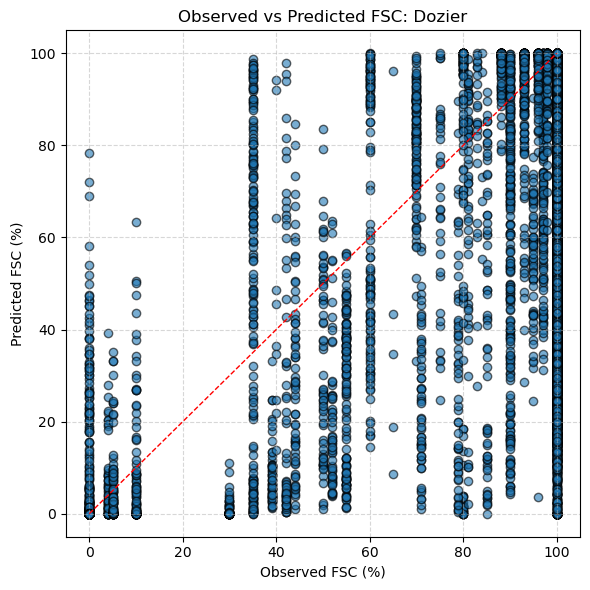

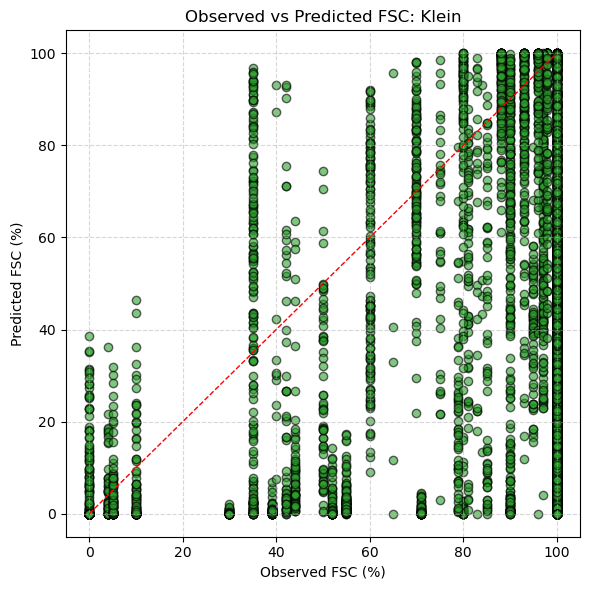

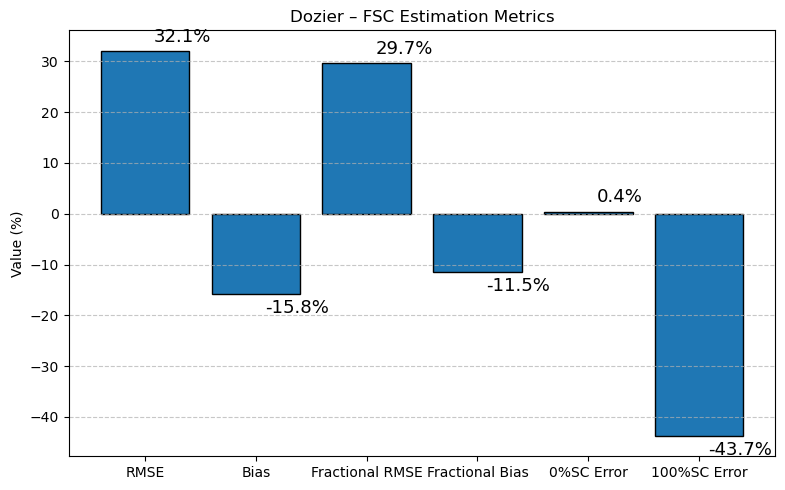

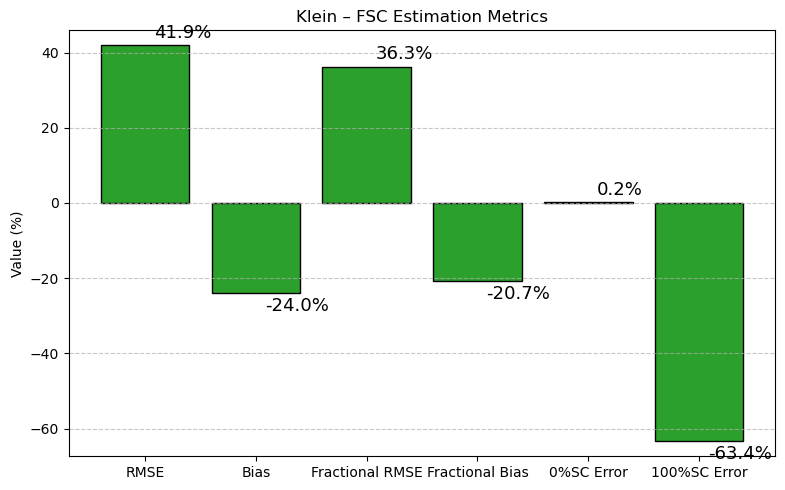

In [3]:
#60m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()


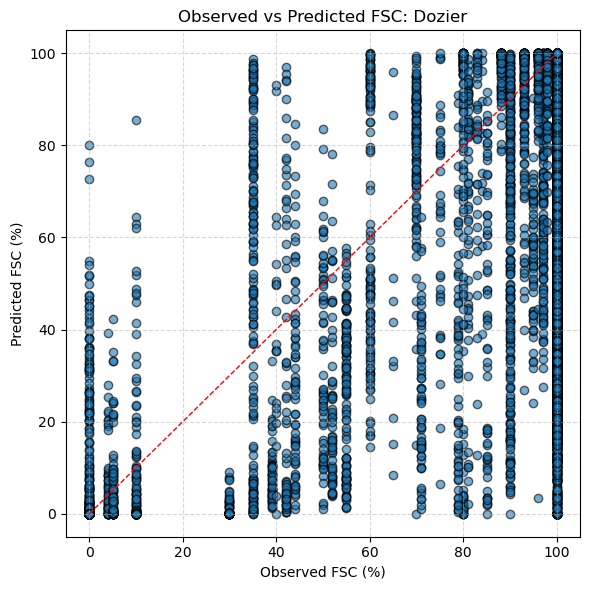

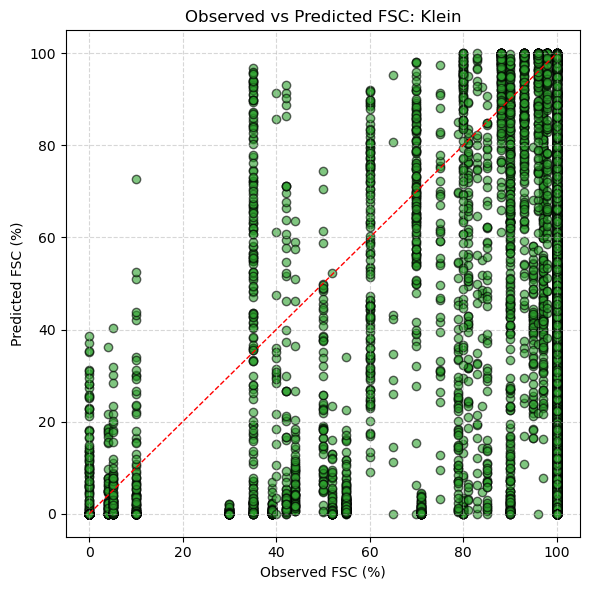

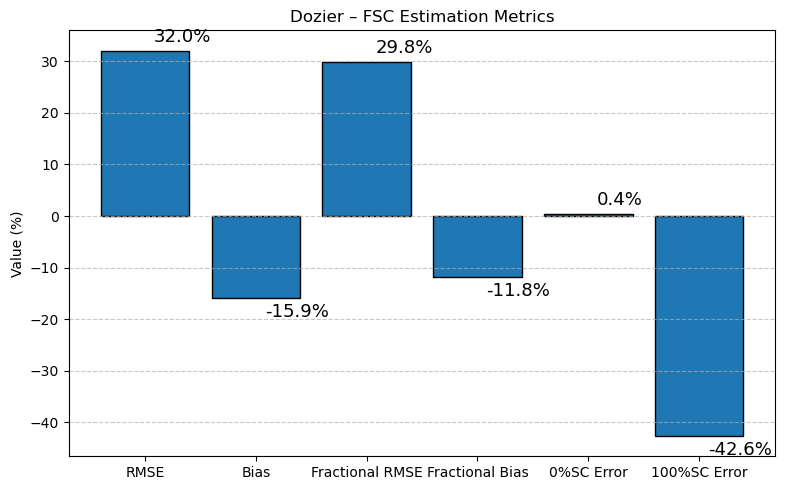

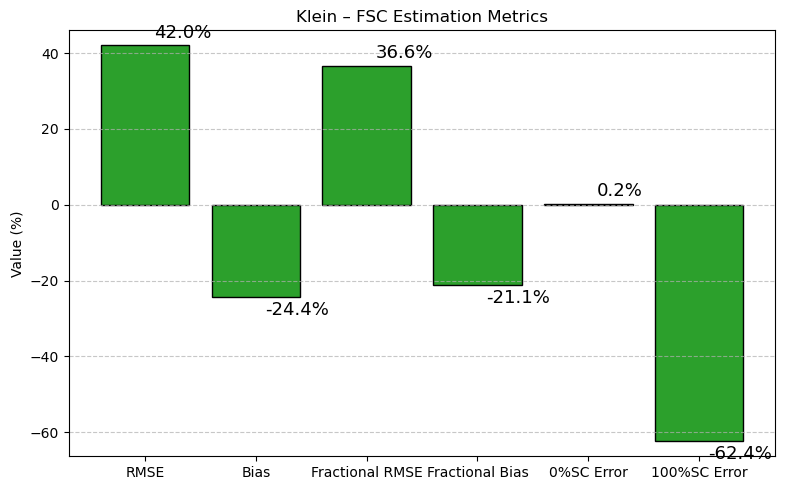

In [5]:
#80m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()


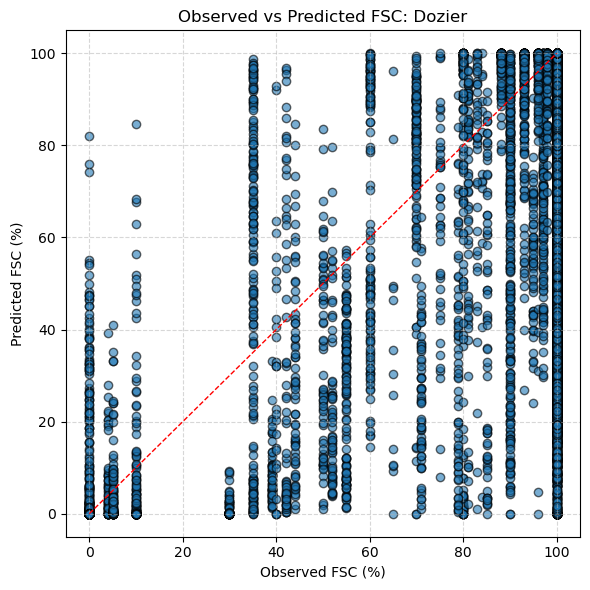

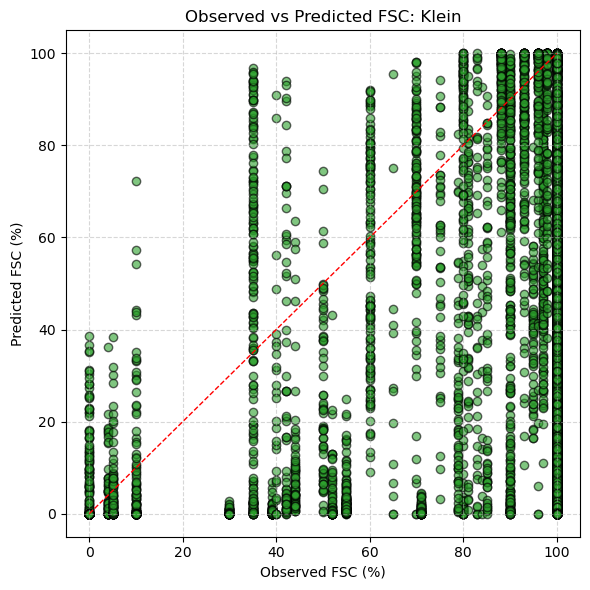

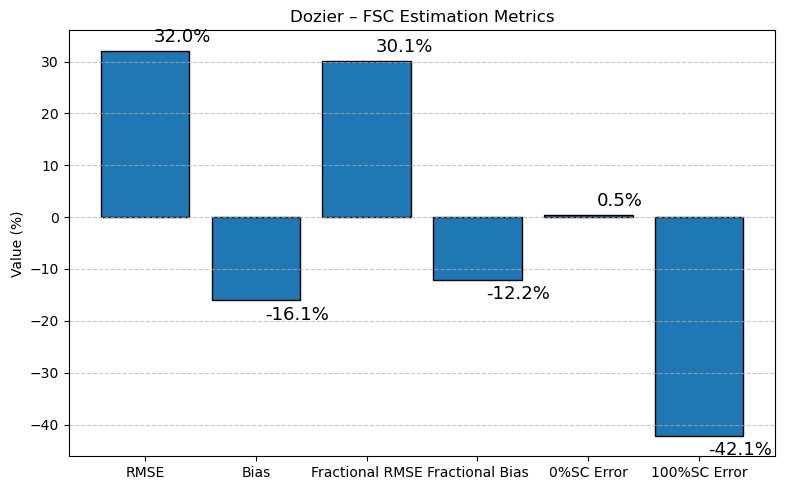

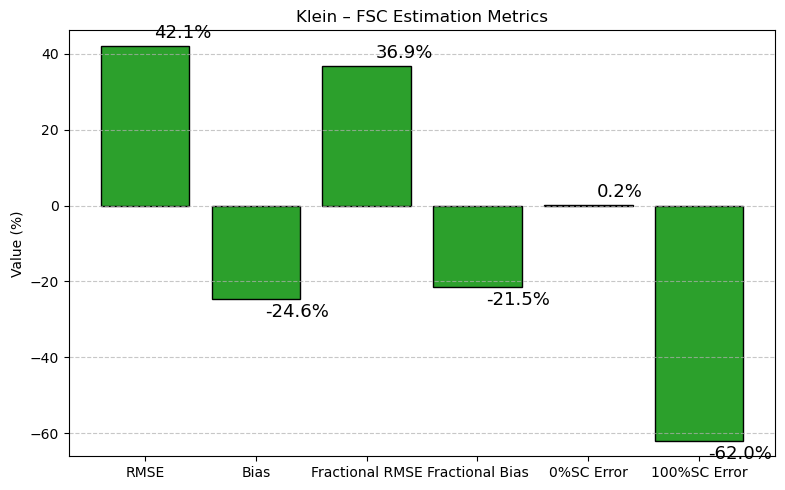

In [9]:
#100m

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein"],  # , "Salomonson"
    var_name="method",
    value_name="predicted"
)

# Convert to percentages for plotting (0–100)
melted["fsc"] = melted["fsc"] * 100.0
melted["predicted"] = melted["predicted"] * 100.0

# Define color map (blue for Dozier, green for Klein)
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    # "Salomonson": "#d62728"
}

# ---------- Scatter: Observed vs Predicted, one figure per method ----------
for method in ["Dozier", "Klein"]:  # , "Salomonson"
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        label=method
    )
    plt.plot([0, 100], [0, 100], 'r--', lw=1)
    plt.xlabel("Observed FSC (%)")
    plt.ylabel("Predicted FSC (%)")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# ---------- Metric helpers ----------
def rmse(y_true, y_pred):
    diff = y_pred - y_true
    return np.sqrt(np.nanmean(diff**2)) if np.isfinite(diff).any() else np.nan

def bias(y_true, y_pred):
    diff = y_pred - y_true
    return np.nanmean(diff) if np.isfinite(diff).any() else np.nan

def compute_all_metrics(df_method):
    """df_method: melted subset for a single method, with fsc/predicted in 0–100 units."""
    y = df_method["fsc"].to_numpy()
    yhat = df_method["predicted"].to_numpy()

    # Overall
    overall_rmse  = rmse(y, yhat)
    overall_bias  = bias(y, yhat)

    # Fractional (strictly between 0 and 100)
    frac_mask = (y > 0) & (y < 100)
    frac_rmse  = rmse(y[frac_mask], yhat[frac_mask])
    frac_bias  = bias(y[frac_mask], yhat[frac_mask])

    # Errors at the extremes
    zero_mask = (y == 0)
    full_mask = (y == 100)

    zero_bias = bias(y[zero_mask], yhat[zero_mask])   # "0%SC Error"
    full_bias = bias(y[full_mask], yhat[full_mask])   # "100%SC Error"

    metrics_order = ["RMSE", "Bias", "Fractional RMSE", "Fractional Bias", "0%SC Error", "100%SC Error"]
    values = np.array([
        overall_rmse,
        overall_bias,
        frac_rmse,
        frac_bias,
        zero_bias,
        full_bias
    ], dtype=float)

    return metrics_order, values

# ---------- Bar chart per method with six metrics ----------
for method in ["Dozier", "Klein"]:
    subset = melted[melted["method"] == method]
    metrics_labels, values = compute_all_metrics(subset)

    plt.figure(figsize=(8, 5))
    x = np.arange(len(metrics_labels))
    bars = plt.bar(x, values, edgecolor='black', color=method_colors[method])

    # Labels on bars (handle NaNs gracefully)
    for bar, val in zip(bars, values):
        height = 0 if np.isnan(val) else float(val)
        txt = "NaN" if np.isnan(val) else f"{height:.1f}%"
        x_offset = bar.get_x() + bar.get_width() * 0.6
        y_offset = 1 * np.sign(height if height != 0 else 1)
        plt.text(
            x_offset,
            height + y_offset,
            txt,
            ha='left',
            va='bottom' if height >= 0 else 'top',
            fontsize=13
        )

    plt.xticks(x, metrics_labels, rotation=0)
    plt.ylabel("Value (%)")
    plt.title(f"{method} – FSC Estimation Metrics")
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Y-lims with padding, robust to NaNs
    finite_vals = values[np.isfinite(values)]
    if finite_vals.size == 0:
        ymin, ymax = -1, 1
    else:
        ymin = min(0.0, float(finite_vals.min())) - 4
        ymax = (float(finite_vals.max()) + 4) if float(finite_vals.max()) > 0 else 1
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_metrics.svg')
    plt.show()


# 1km extent results

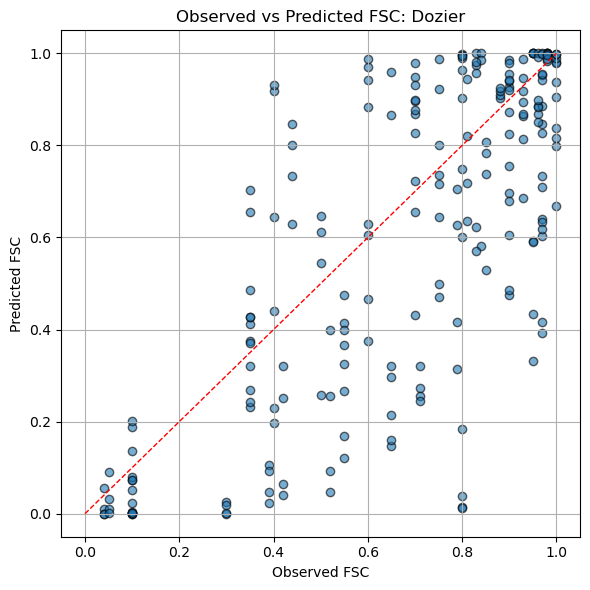

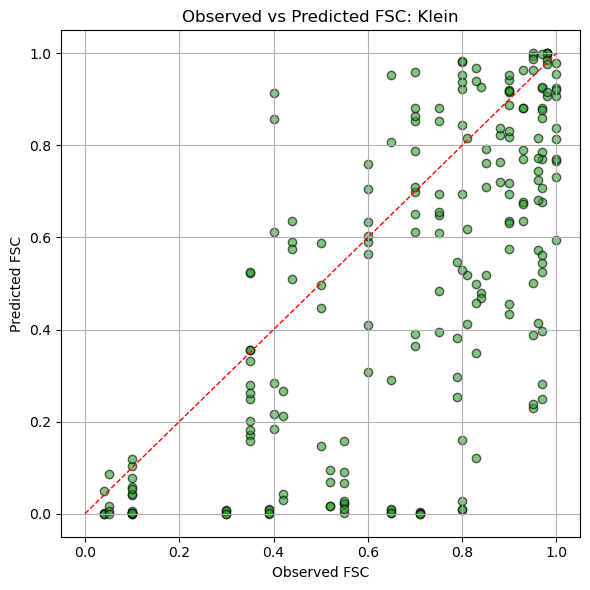

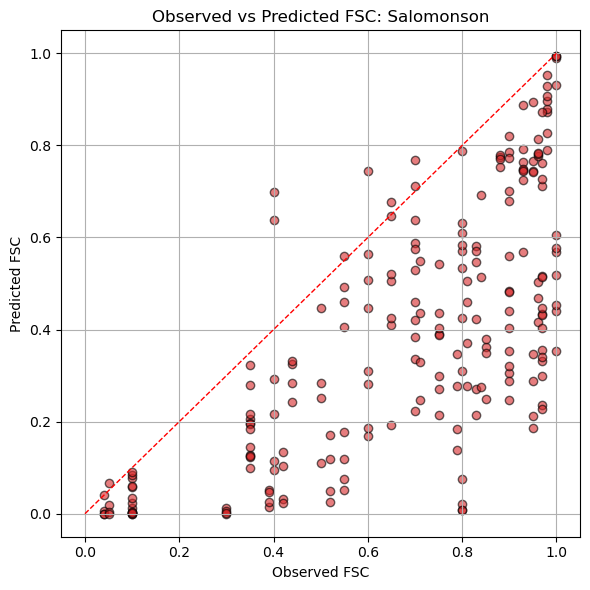

/tmp/ipykernel_3512661/2148821787.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = melted.groupby("method").apply(compute_rmse_bias).reset_index()
/tmp/ipykernel_3512661/2148821787.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=metrics, x="method", y="RMSE", ax=axes[0], palette=method_colors)
/tmp/ipykernel_3512661/2148821787.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barpl

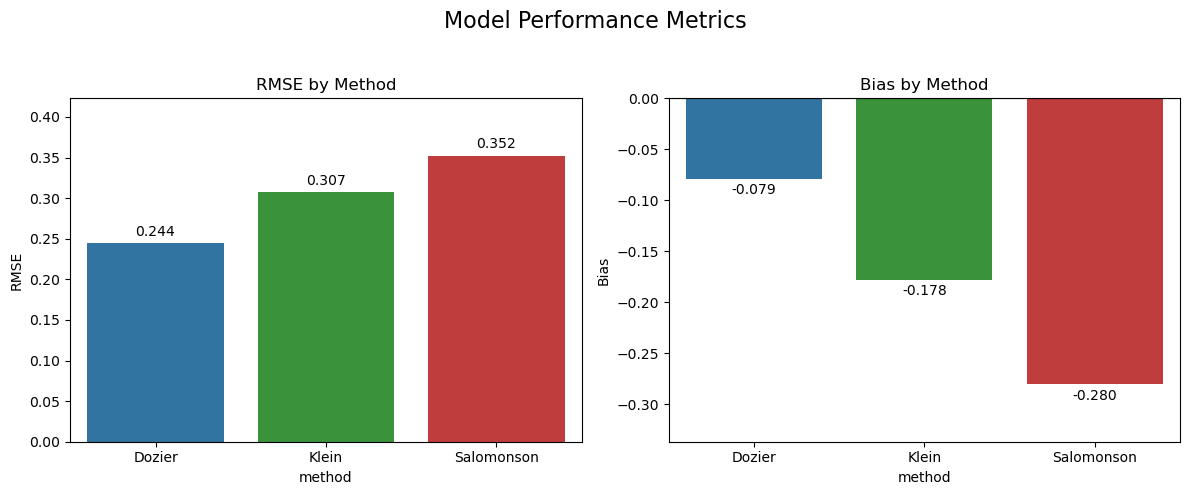

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Melt the dataframe to long format for individual method plots
melted = final_df.melt(
    id_vars=["fsc", "filtered_fraction", "cam"],
    value_vars=["Dozier", "Klein", "Salomonson"],
    var_name="method",
    value_name="predicted"
)

# Define color map for consistency
method_colors = {
    "Dozier": "#1f77b4",
    "Klein": "#2ca02c",
    "Salomonson": "#d62728"
}

# Loop through methods and plot
for method in ["Dozier", "Klein", "Salomonson"]:
    subset = melted[melted["method"] == method]

    plt.figure(figsize=(6, 6))
    plt.scatter(
        subset["fsc"],
        subset["predicted"],
        alpha=0.6,
        edgecolor='k',
        c=method_colors[method],
        # s=subset["filtered_fraction"] * 200 + 20,
        label=method
    )
    plt.plot([0, 1], [0, 1], 'r--', lw=1)
    plt.xlabel("Observed FSC")
    plt.ylabel("Predicted FSC")
    plt.title(f"Observed vs Predicted FSC: {method}")
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f'poster_landsat_{method}_actual_predicted.svg')
    plt.show()

# Compute RMSE and Bias
def compute_rmse_bias(group):
    rmse = np.sqrt(np.mean((group["predicted"] - group["fsc"])**2))
    bias = np.mean(group["predicted"] - group["fsc"])
    return pd.Series({"RMSE": rmse, "Bias": bias})

metrics = melted.groupby("method").apply(compute_rmse_bias).reset_index()

# Barplot of RMSE and Bias
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=metrics, x="method", y="RMSE", ax=axes[0], palette=method_colors)
axes[0].set_title("RMSE by Method")
axes[0].set_ylim(0, metrics["RMSE"].max() * 1.2)
for container in axes[0].containers:
    axes[0].bar_label(container, labels=[f"{v.get_height():.3f}" for v in container], padding=3)

sns.barplot(data=metrics, x="method", y="Bias", ax=axes[1], palette=method_colors)
axes[1].set_title("Bias by Method")
axes[1].axhline(0, color='black', lw=0.8)
axes[1].set_ylim(
    min(0, metrics["Bias"].min()) * 1.2,
    max(0, metrics["Bias"].max()) * 1.2
)
for container in axes[1].containers:
    axes[1].bar_label(container, labels=[f"{v.get_height():.3f}" for v in container], padding=3)

plt.suptitle("Model Performance Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig('poster_landsat_rmse.svg')
plt.show()
